## Experiment1: L1, L2 and L1, L2 combination penalties

In [1]:
import numpy as np
from mlp.layers import Layer
    
class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

In [48]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)
    
    
class L1L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 and L2 norm.
    """

    def __init__(self, coefficientL1,coefficientL2):
        """Create a new L1L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficientL1 > 0., 'Penalty coefficient must be positive.'
        self.coefficientL1 = coefficientL1
        self.coefficientL2 = coefficientL2
        
    def __call__(self, parameter):
        """Calculate L1L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficientL1 * abs(parameter).sum() + 0.5 * 0.5 * self.coefficientL2 * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return 0.5 * self.coefficientL1 * np.sign(parameter) + 0.5 * self.coefficientL2 * parameter
    
    def __repr__(self):
        return 'L1Penalty({0}), L2Penalty({1})'.format(self.coefficientL1, self.coefficientL2)

In [49]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [4]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2),
    L1L2Penalty(1e-5,1e-4),
    L1L2Penalty(1e-3,1e-2),
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=0.00e+00
Epoch 5: 1.31s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.29s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.34s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.30s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.30s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.30s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.30s to complet

Regularisation: L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e-02
Epoch 5: 1.91s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.88s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 1.88s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 1.88s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 1.90s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 1.88s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 1.90s to complet

Regularisation: L1Penalty(0.001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e+00
Epoch 5: 1.88s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 1.88s to complete
  error(train)=2.22e-01, acc(train)=9.35e-01, error(valid)=2.15e-01, acc(valid)=9.37e-01, params_penalty=2.76e-01
Epoch 15: 1.90s to complete
  error(train)=2.27e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.37e-01, params_penalty=2.60e-01
Epoch 20: 1.89s to complete
  error(train)=2.80e-01, acc(train)=9.14e-01, error(valid)=2.62e-01, acc(valid)=9.19e-01, params_penalty=2.63e-01
Epoch 25: 1.89s to complete
  error(train)=2.37e-01, acc(train)=9.28e-01, error(valid)=2.33e-01, acc(valid)=9.29e-01, params_penalty=2.58e-01
Epoch 30: 1.89s to complete
  error(train)=2.25e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.39e-01, params_penalty=2.54e-01
Epoch 35: 1.89s to complet

Regularisation: L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-03
Epoch 5: 1.81s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 1.48s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 1.47s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 1.45s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.45s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 1.45s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 1.45s to complet

Regularisation: L2Penalty(0.01)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-01
Epoch 5: 1.44s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 1.45s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 1.44s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 1.47s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 1.45s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 1.47s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 1.44s to complet

Regularisation: L1Penalty(1e-05), L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.23e-02
Epoch 5: 2.08s to complete
  error(train)=6.42e-02, acc(train)=9.82e-01, error(valid)=9.34e-02, acc(valid)=9.73e-01, params_penalty=2.08e-02
Epoch 10: 2.08s to complete
  error(train)=2.73e-02, acc(train)=9.92e-01, error(valid)=7.99e-02, acc(valid)=9.77e-01, params_penalty=2.37e-02
Epoch 15: 2.08s to complete
  error(train)=1.57e-02, acc(train)=9.96e-01, error(valid)=8.31e-02, acc(valid)=9.77e-01, params_penalty=2.52e-02
Epoch 20: 2.07s to complete
  error(train)=6.77e-03, acc(train)=9.99e-01, error(valid)=8.58e-02, acc(valid)=9.78e-01, params_penalty=2.56e-02
Epoch 25: 2.08s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.52e-02
Epoch 30: 2.09s to complete
  error(train)=2.68e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.45e-02
Epoch 35: 2.07s to complet

Regularisation: L1Penalty(0.001), L2Penalty(0.01)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=1.23e+00
Epoch 5: 2.07s to complete
  error(train)=2.61e-01, acc(train)=9.31e-01, error(valid)=2.42e-01, acc(valid)=9.38e-01, params_penalty=3.43e-01
Epoch 10: 2.08s to complete
  error(train)=2.35e-01, acc(train)=9.36e-01, error(valid)=2.18e-01, acc(valid)=9.41e-01, params_penalty=3.18e-01
Epoch 15: 2.09s to complete
  error(train)=2.37e-01, acc(train)=9.37e-01, error(valid)=2.17e-01, acc(valid)=9.42e-01, params_penalty=3.13e-01
Epoch 20: 2.08s to complete
  error(train)=2.54e-01, acc(train)=9.30e-01, error(valid)=2.34e-01, acc(valid)=9.37e-01, params_penalty=3.13e-01
Epoch 25: 2.07s to complete
  error(train)=2.38e-01, acc(train)=9.36e-01, error(valid)=2.24e-01, acc(valid)=9.39e-01, params_penalty=3.09e-01
Epoch 30: 2.07s to complete
  error(train)=2.25e-01, acc(train)=9.42e-01, error(valid)=2.11e-01, acc(valid)=9.49e-01, params_penalty=3.10e-01
Epoch 35: 2.07s to complet

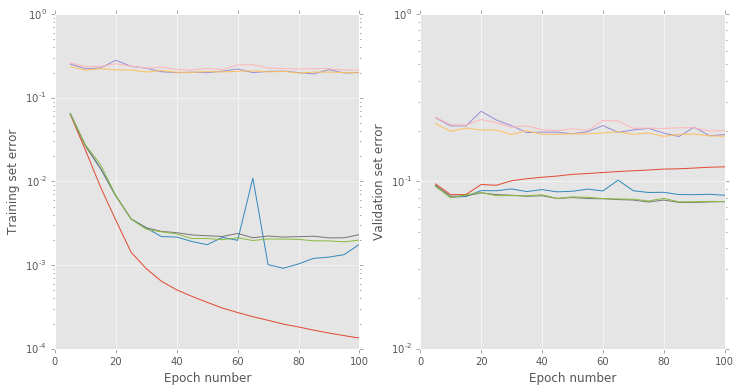

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']]) #label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']]) #label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
#fig.savefig('L1L2error.pdf')

In [20]:
def plot_param_histogram(weight_penalty,param, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    fig.savefig( str(weight_penalty) +'histogram.pdf')
    return fig, ax

def visualise_first_layer_weights(weights, fig_size=(5, 5)):
    """Plots a grid of first layer weights as feature maps."""
    fig = plt.figure(figsize=fig_size)
    num_feature_maps = weights.shape[0]
    grid_size = int(num_feature_maps**0.5)
    max_abs = np.abs(model.params[0]).max()
    tiled = -np.ones((30 * grid_size, 
                      30 * num_feature_maps // grid_size)) * max_abs
    for i, fm in enumerate(model.params[0]):
        r, c = i % grid_size, i // grid_size
        tiled[1 + r * 30:(r + 1) * 30 - 1, 
              1 + c * 30:(c + 1) * 30 - 1] = fm.reshape((28, 28))
    ax = fig.add_subplot(111)
    max_abs = np.abs(tiled).max()
    ax.imshow(tiled, cmap='Greys', vmin=-max_abs, vmax=max_abs)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    #fig.savefig('visualise.pdf')
    return fig, ax

Regularisation: None


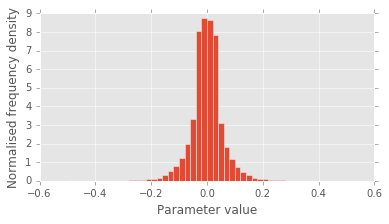

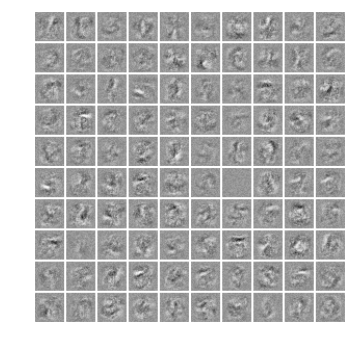

Regularisation: L1Penalty(1e-05)


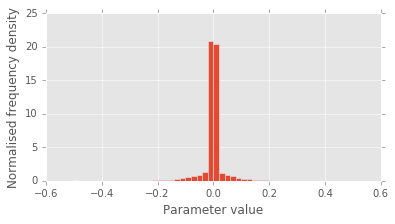

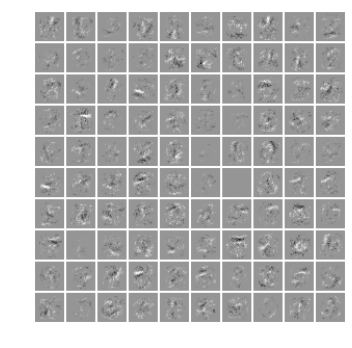

Regularisation: L1Penalty(0.001)


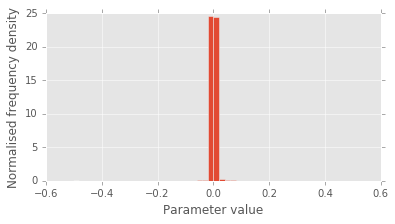

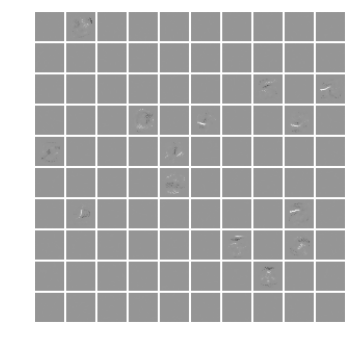

Regularisation: L2Penalty(0.0001)


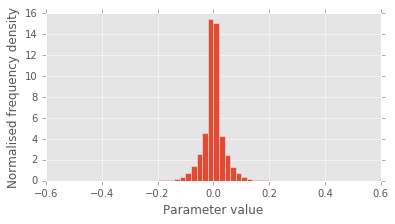

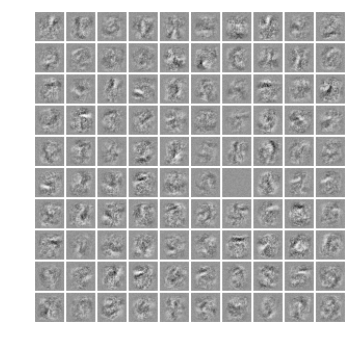

Regularisation: L2Penalty(0.01)


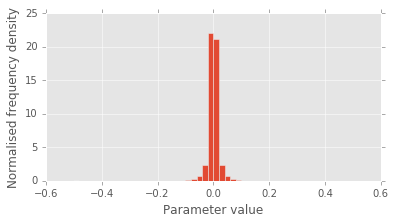

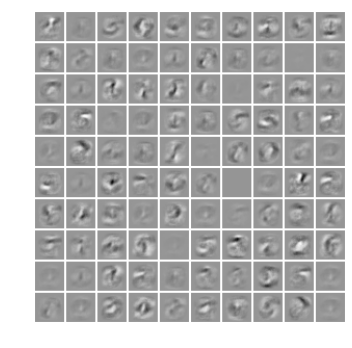

Regularisation: L1Penalty(1e-05), L2Penalty(0.0001)


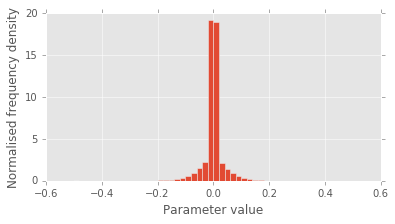

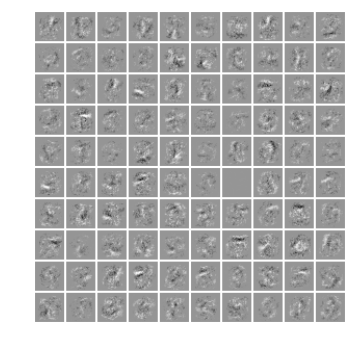

Regularisation: L1Penalty(0.001), L2Penalty(0.01)


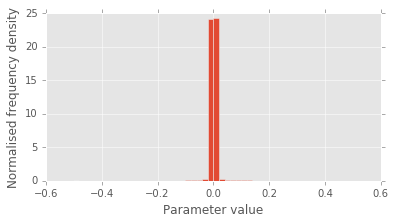

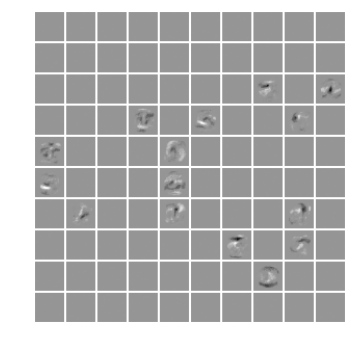

In [21]:
for weight_penalty, model in models.items():
    print('Regularisation: {0}'.format(weight_penalty))
    _ = plot_param_histogram(weight_penalty,model.params[0], interval=[-0.5, 0.5])
    _ = visualise_first_layer_weights(model.params[0])

## Experiment2: Data augmentation

In [39]:
from scipy.ndimage.interpolation import rotate

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

In [40]:
from scipy.ndimage.interpolation import shift

def random_shift(inputs, rng):
    """Randomly shifts a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images shifted by a random space. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    shifts = np.random.randint(1,5)
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], shifts)
    return new_ims.reshape((-1, 784))

In [41]:
def random_gaussian_noise(inputs, rng):
    """Randomly add some noise to a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images changed by adding some random noise. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    mean = 0
    var = 0.1
    sigma = var**0.5
    for i, j in enumerate(indices):
        noise = np.random.normal(mean,sigma,size=(1,1))
        new_ims[j] = orig_ims[j] + noise
    return new_ims.reshape((-1, 784))

In [42]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def random_distortion_sigma(inputs, rng, alpha=34, sigma=4):
    """Randomly distort a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        alpha: A parameter to change the intensity.
        sigma: A parameter to change the intensity.
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images distor by adding some random noise. The original `inputs`
        array should not be modified.
    """
    assert len(inputs.shape)==2

    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    shape = orig_ims[0].shape

    for i, j in enumerate(indices):
        dx = gaussian_filter((rng.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        dy = gaussian_filter((rng.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        i = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
        new_ims[j] = map_coordinates(orig_ims[j], i, order=1).reshape(shape)
    
    return new_ims.reshape((-1,784))

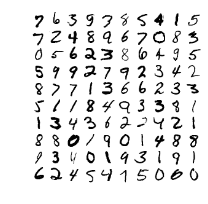

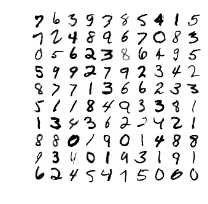

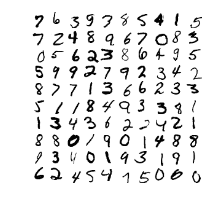

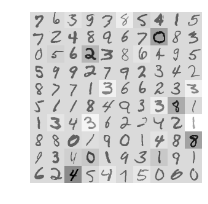

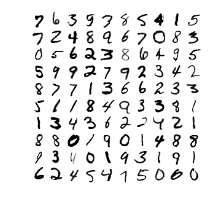

In [43]:
from mlp.data_providers import MNISTDataProvider
import matplotlib.pyplot as plt
%matplotlib inline
def show_batch_of_images(img_batch,filename,fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    fig.savefig(filename)
    return fig, ax

test_data = MNISTDataProvider('test', 100, rng=rng)
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)),'original.pdf')

transformed_inputs = random_rotation(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),"random_rotation.pdf")
transformed_inputs = random_shift(inputs, rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),"random_shift.pdf")
transformed_inputs = random(inputs,rng)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),"random_noise.pdf")
transformed_inputs = random_distortion(inputs, rng,34,8)
_ = show_batch_of_images(transformed_inputs.reshape((-1, 28, 28)),"random_distortion.pdf")



In [16]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from mlp.layers import AffineLayer, ReshapeLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import AugmentedMNISTDataProvider, MNISTDataProvider
from mlp.optimisers import Optimiser
from collections import OrderedDict
%matplotlib inline
# Seed a random number generator
seed = 24102016 
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5
input_dim, output_dim, hidden_dim = 784, 10, 100
stats_interval = 5
weights_init_gain = 0.5
biases_init = 0.
rng = np.random.RandomState(seed)



In [30]:
transform_list = [
    "initial data",
    random_rotation,
    random_shift,
    random_gaussian_noise,
    random_distortion
]

#aug_train_data = MNISTDataProvider('train', batch_size, rng=rng)
weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

run_info = OrderedDict()
models = OrderedDict()


for transformer in transform_list:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    if transformer == "initial data":
        aug_train_data = MNISTDataProvider('train', batch_size,rng=rng)
    else:
        aug_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=transformer)

    model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
     ])

    valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
    aug_train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size
    rng.seed(seed)
    aug_train_data.reset()
    valid_data.reset()
    print('transformer: {0}'.format(str(transformer)))
    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(
        model, error, learning_rule, aug_train_data, valid_data, data_monitors)
    run_info[transformer] = optimiser.train(num_epochs, stats_interval)
    models[transformer] = model
     

transformer: initial data


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.79e-02, error(valid)=2.30e+00, acc(valid)=9.99e-02, params_penalty=0.00e+00
Epoch 5: 1.13s to complete
  error(train)=1.17e-01, acc(train)=9.66e-01, error(valid)=1.28e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 10: 1.26s to complete
  error(train)=5.84e-02, acc(train)=9.83e-01, error(valid)=9.63e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 1.15s to complete
  error(train)=2.86e-02, acc(train)=9.93e-01, error(valid)=7.80e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 0.97s to complete
  error(train)=1.74e-02, acc(train)=9.96e-01, error(valid)=7.59e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 25: 1.08s to complete
  error(train)=1.25e-02, acc(train)=9.98e-01, error(valid)=8.31e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.04s to complete
  error(train)=5.24e-03, acc(train)=1.00e+00, error(valid)=7.97e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 35: 0.94s to complet

transformer: <function random_rotation at 0x109d72a28>


Epoch 0:
  error(train)=2.31e+00, acc(train)=8.65e-02, error(valid)=2.31e+00, acc(valid)=7.30e-02, params_penalty=0.00e+00
Epoch 5: 2.29s to complete
  error(train)=1.51e-01, acc(train)=9.56e-01, error(valid)=1.25e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 10: 2.29s to complete
  error(train)=8.52e-02, acc(train)=9.75e-01, error(valid)=8.90e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 2.49s to complete
  error(train)=6.70e-02, acc(train)=9.80e-01, error(valid)=7.89e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 2.30s to complete
  error(train)=5.29e-02, acc(train)=9.85e-01, error(valid)=7.52e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 25: 2.30s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.45e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 2.36s to complete
  error(train)=3.81e-02, acc(train)=9.89e-01, error(valid)=7.30e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 35: 2.20s to complet

transformer: <function random_shift at 0x109d72c80>


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.51e-01, error(valid)=2.30e+00, acc(valid)=1.65e-01, params_penalty=0.00e+00
Epoch 5: 2.63s to complete
  error(train)=1.48e-01, acc(train)=9.56e-01, error(valid)=1.22e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 10: 2.63s to complete
  error(train)=9.41e-02, acc(train)=9.72e-01, error(valid)=1.01e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 2.64s to complete
  error(train)=8.19e-02, acc(train)=9.75e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 20: 2.65s to complete
  error(train)=4.92e-02, acc(train)=9.86e-01, error(valid)=8.07e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 2.65s to complete
  error(train)=4.45e-02, acc(train)=9.87e-01, error(valid)=8.31e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 2.81s to complete
  error(train)=3.39e-02, acc(train)=9.90e-01, error(valid)=8.20e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 2.56s to complet

transformer: <function random_distortion at 0x10f3669b0>


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.22e-01, error(valid)=2.30e+00, acc(valid)=1.27e-01, params_penalty=0.00e+00
Epoch 5: 6.27s to complete
  error(train)=2.15e-01, acc(train)=9.36e-01, error(valid)=1.08e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 10: 6.23s to complete
  error(train)=1.52e-01, acc(train)=9.53e-01, error(valid)=8.24e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 15: 6.41s to complete
  error(train)=1.24e-01, acc(train)=9.62e-01, error(valid)=6.78e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 20: 6.16s to complete
  error(train)=1.06e-01, acc(train)=9.68e-01, error(valid)=6.13e-02, acc(valid)=9.81e-01, params_penalty=0.00e+00
Epoch 25: 6.26s to complete
  error(train)=9.78e-02, acc(train)=9.71e-01, error(valid)=5.70e-02, acc(valid)=9.85e-01, params_penalty=0.00e+00
Epoch 30: 6.40s to complete
  error(train)=9.11e-02, acc(train)=9.72e-01, error(valid)=5.95e-02, acc(valid)=9.84e-01, params_penalty=0.00e+00
Epoch 35: 6.41s to complet

transformer: <function random_noise at 0x109d72ed8>


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.01e-01, error(valid)=2.30e+00, acc(valid)=9.99e-02, params_penalty=0.00e+00
Epoch 5: 1.06s to complete
  error(train)=1.14e-01, acc(train)=9.67e-01, error(valid)=1.20e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 10: 1.08s to complete
  error(train)=5.76e-02, acc(train)=9.83e-01, error(valid)=8.28e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 1.06s to complete
  error(train)=3.48e-02, acc(train)=9.91e-01, error(valid)=7.96e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 1.07s to complete
  error(train)=2.07e-02, acc(train)=9.95e-01, error(valid)=7.65e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 1.14s to complete
  error(train)=1.65e-02, acc(train)=9.95e-01, error(valid)=8.47e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.06s to complete
  error(train)=2.32e-02, acc(train)=9.94e-01, error(valid)=8.41e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 1.18s to complet

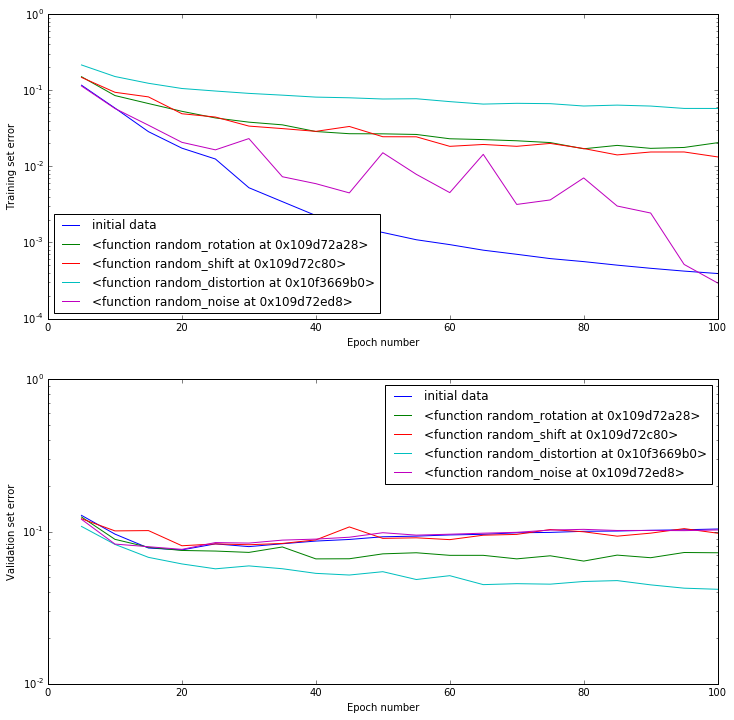

In [31]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for transformer, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(transformer))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(transformer))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')
fig.savefig('all_situation.pdf')

## Experiment3: Convolutional layer

In [2]:
import mlp.layers as layers
import mlp.initialisers as init
from scipy import signal

class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape (batch_size, input_dim).

        Returns:
            outputs: Array of layer outputs of shape (batch_size, output_dim).
        """
        batch_size = inputs.shape[0]
        a = []
        for i in range(batch_size):
            b = []
            for j in range(self.num_output_channels):
                c = []
                for k in range(self.num_input_channels):
                    c.append(signal.convolve2d(inputs[i,k], self.kernels[j,k],mode='valid'))
                b.append(sum(c)+self.biases[j])
            a.append(b)
        return(np.array(a))

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, input_dim).
        """
        batch_size = inputs.shape[0]
        a = []
        for i in range(batch_size):
            b = []
            for k in range(self.num_input_channels):
                c = 0
                for j in range(self.num_output_channels):
                    c += (signal.convolve2d(np.rot90(self.kernels[j][k],2),grads_wrt_outputs[i][j]))
                b.append(c)
            a.append(b)
        return np.array(a)

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        
        """
    
        grads_wrt_kernels = np.zeros([self.num_output_channels, self.num_input_channels, self.kernel_dim_1,
                                    self.kernel_dim_2])
        
        grads_wrt_biases = np.zeros([self.num_output_channels])
        
        for i in range(self.num_output_channels):
            grads_wrt_biases[i] = np.sum(grads_wrt_outputs[:,i])
            for j in range(self.num_input_channels):
                result = 0
                for k in range(self.num_output_channels):
                    result +=  signal.convolve2d(np.rot90(inputs[k][j],2),grads_wrt_outputs[k][i],'valid')
                grads_wrt_kernels[i,j] = result
                
        if self.kernels_penalty is not None:
            grads_wrt_kernels += self.kernels_penalty.grad(self.kernels)
        
        if self.biases_penalty is not None:
            grads_wrt_biases  += self.biases_penalty.grad(self.biases)
        
        return [grads_wrt_kernels, grads_wrt_biases]
            
    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

In [3]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from mlp.layers import AffineLayer, ReshapeLayer, MaxPoolingLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import AugmentedMNISTDataProvider, MNISTDataProvider
from mlp.optimisers import Optimiser
from collections import OrderedDict
%matplotlib inline
# Seed a random number generator
seed = 24102016 
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5
input_dim, output_dim, hidden_dim = 784, 10, 100
num_input_channels, num_output_channels = 1, 1
input_dim1, input_dim2 = 28, 28
output_dim1, output_dim2 = 24, 24 #input_dim1 - kernel_dim1 + 1
kernel_dim1, kernel_dim2 = 5, 5
stats_interval = 5
weights_init_gain = 0.5
biases_init = 0.
rng = np.random.RandomState(seed)

In [14]:
cnns = ["cnn"]
weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

run_info = OrderedDict()
models = OrderedDict()
for cnn in cnns:
    train_data = MNISTDataProvider('train', batch_size, rng=rng)
    model = MultipleLayerModel([
    ReshapeLayer((num_input_channels,input_dim1,input_dim2)),
    ConvolutionalLayer(num_input_channels,num_output_channels,input_dim1,input_dim2,
                      kernel_dim1, kernel_dim2,),
    ReshapeLayer((num_output_channels*output_dim1*output_dim2,)),
    AffineLayer(num_output_channels*output_dim1*output_dim2, hidden_dim, weights_init, 
                    biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init)
     ])

    valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
    aug_train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size
    rng.seed(seed)
    aug_train_data.reset()
    valid_data.reset()

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    run_info[cnn] = optimiser.train(num_epochs, stats_interval)
    models[cnn] = model
    

Epoch 0:
  error(train)=2.30e+00, acc(train)=6.65e-02, error(valid)=2.30e+00, acc(valid)=6.85e-02, params_penalty=0.00e+00
Epoch 5: 55.10s to complete
  error(train)=1.31e-01, acc(train)=9.60e-01, error(valid)=1.31e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 10: 62.75s to complete
  error(train)=8.73e-02, acc(train)=9.72e-01, error(valid)=1.05e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 15: 60.75s to complete
  error(train)=5.97e-02, acc(train)=9.81e-01, error(valid)=8.82e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 20: 85.88s to complete
  error(train)=4.33e-02, acc(train)=9.86e-01, error(valid)=8.12e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 117.87s to complete
  error(train)=3.77e-02, acc(train)=9.88e-01, error(valid)=8.27e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 102.95s to complete
  error(train)=3.10e-02, acc(train)=9.90e-01, error(valid)=8.85e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 35: 60.95s t

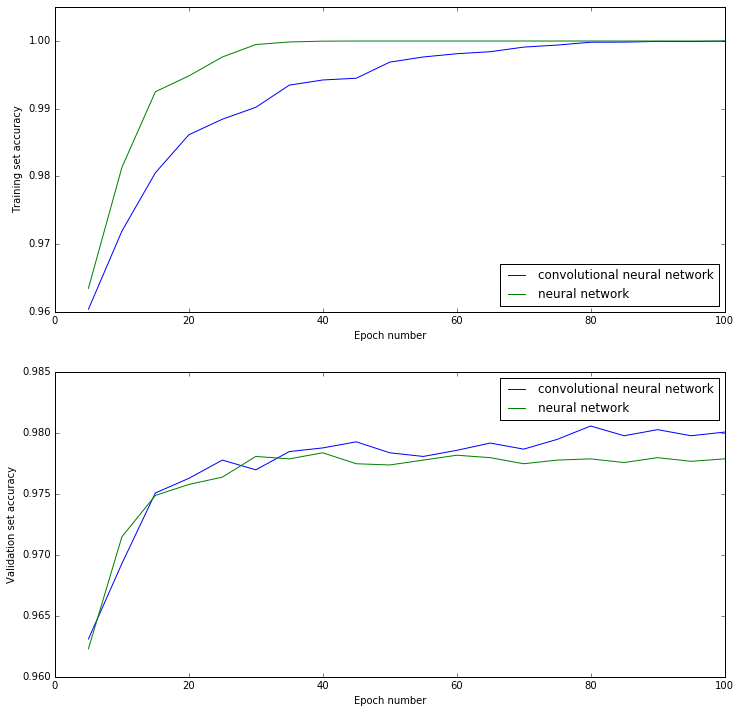

In [18]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for transformer, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']], label="convolutional neural network")
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']], label="convolutional neural network")
for transformer, run in run_info1.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(train)']], label="neural network")
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['acc(valid)']], label="neural network")
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')

ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set accuracy')
